# Questão 1

## Carregando o conjunto de dados

In [1]:
import pandas as pd
import numpy as np

fatura_df = pd.read_table('datasets/Questão 1 - Base.txt')
fatura_df['DT_VENCIMENTO'] = pd.to_datetime(fatura_df['DT_VENCIMENTO'])
display(fatura_df.head())

,ID_CONTA,DT_VENCIMENTO,DS_ROLAGEM,VL_FATURA
0,402467,2019-01-01,FX0,210.00
1,403001,2019-01-01,FX1,1097.18
2,403499,2019-01-01,FX0,1209.88
3,403670,2019-01-01,FX0,667.40
4,404183,2019-01-01,FX1,1239.52


## 1.1 Percentual de faturas emitidas por mês com fatura anterior não paga

In [2]:
# Dataframe onde cada entrada é o número de faturas para um dado mês e um 
# valor de DS_ROLAGEM.
mes_rolagem_df = pd.pivot_table(fatura_df, values='DT_VENCIMENTO', 
                                index=fatura_df['DT_VENCIMENTO'].dt.month, 
                                columns='DS_ROLAGEM', aggfunc='count')

# número de faturas por mês
numero_faturas_por_mes = mes_rolagem_df.sum(axis=1)

# calculando porcentagem
mes_rolagem_df['FX1'] = round((mes_rolagem_df['FX1'] / numero_faturas_por_mes) * 100, 2)

# formatando dataframe
mes_fx1_df = mes_rolagem_df.drop(columns='FX0')
mes_fx1_df.index.name = 'MES DE VENCIMENTO'
mes_fx1_df.columns = ['FX1 (%)']

# resultado
mes_fx1_df

,FX1 (%)
MES DE VENCIMENTO,
1,7.29
2,8.90
3,10.88
4,8.39
5,10.04
6,8.53
7,9.61
8,9.06
9,8.54


## 1.2 - Últimos 6 meses de faturas de setembro

In [3]:
# clientes com fatura em setembro
faturas_setembro = fatura_df[fatura_df['DT_VENCIMENTO'].dt.month == 9]

# últimos 6 meses (mar - ago)
ultimos_seis_meses = fatura_df[(2 < fatura_df['DT_VENCIMENTO'].dt.month) & 
                               (fatura_df['DT_VENCIMENTO'].dt.month < 9)]

# filtrando clientes
ultimos_seis_meses = ultimos_seis_meses[ultimos_seis_meses['ID_CONTA'].isin(faturas_setembro['ID_CONTA'])]

# marcando linhas com DS_ROLAGEM == FX1 para contagem
ultimos_seis_meses['TEM_FX1'] =  ultimos_seis_meses['DS_ROLAGEM'] == 'FX1'

# calculando quantidade de faturas e valor médio delas nos últimos 6 meses
novos_atr = ultimos_seis_meses.groupby('ID_CONTA').agg(QTD_FATURAS_ULT_6M=('ID_CONTA', 'count'), 
                                                       VL_MEDIO_FATURA=('VL_FATURA', 'mean'), 
                                                       QTD_FATURAS_ULT_6M_FX1=('TEM_FX1', 'sum'))

# left join entre faturas_setembro e novos_atr_df
resultado = faturas_setembro.merge(novos_atr, on='ID_CONTA', how='left', sort=True)
# os valores nulos representam ausência de faturas anteriores, 
# por isso preencherei com 0's
resultado.fillna(0, inplace=True)

# resultado
resultado.head()

,ID_CONTA,DT_VENCIMENTO,DS_ROLAGEM,VL_FATURA,QTD_FATURAS_ULT_6M,VL_MEDIO_FATURA,QTD_FATURAS_ULT_6M_FX1
0,27717,2019-09-20,FX0,878.89,6.0,1623.128333,0.0
1,27789,2019-09-10,FX0,848.69,6.0,913.355000,0.0
2,29755,2019-09-05,FX0,5782.58,0.0,0.000000,0.0
3,30256,2019-09-08,FX0,180.95,6.0,441.881667,0.0
4,35473,2019-09-10,FX0,808.52,6.0,882.268333,0.0


## 1.3 - Variável com maior potencial

Para encontrar o atributo de maior potencial preditivo, apliquei o método de regressão logística separadamente em cada atributo. A avaliação dos resultados foi feita com a acurácia e o AUC da curva ROC. Os resultados são apresentados no gráfico abaixo. Nesse gráfico, podemos ver que as duas métricas indicam que a variável de maior potencial preditivo é a <i>QTD_FATURAS_ULT_6M_FX1</i>.

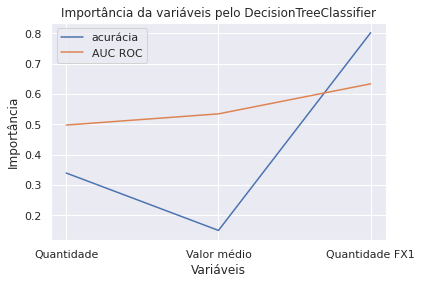

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

X = resultado.iloc[:, 4:].values
y = resultado['DS_ROLAGEM'] == 'FX1'

accs = []
aucs = []

for i in range(X.shape[1]):
    logreg = LogisticRegression(class_weight='balanced')
    X_train, X_test, y_train, y_test = train_test_split(X[:, i].reshape(-1, 1), y, 
                                                        test_size=0.25, stratify=y, random_state=42)
    
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    accs.append(accuracy_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_pred))
    
sns.set()
plt.title("Importância da variáveis pelo DecisionTreeClassifier")
plt.plot(range(3), accs, label='acurácia')
plt.plot(range(3), aucs, label='AUC ROC')
plt.xticks(range(3), ['Quantidade', 'Valor médio', 'Quantidade FX1'])
plt.xlabel('Variáveis')
plt.ylabel('Importância')
plt.legend()
plt.show()

# Questão 2
## Carregando o conjunto de dados

In [5]:
base1 = pd.read_table('datasets/Questão 2 - Base 1.txt', parse_dates=['DT_ACORDO'])
base2 = pd.read_table('datasets/Questão 2 - Base 2.txt', parse_dates=['DT_ACORDO'])
base3 = pd.read_table('datasets/Questão 2 - Base 3.txt', parse_dates=['DT_ACORDO'])
base4 = pd.read_table('datasets/Questão 2 - Base 4.txt', parse_dates=['DT_ACORDO'])
base5 = pd.read_table('datasets/Questão 2 - Base 5.txt', parse_dates=['DT_ACORDO'])

# juntando todas as bases
divida_df = base1.merge(base2, on=['ID_CONTA', 'DT_ACORDO'])
divida_df = divida_df.merge(base3, on=['ID_CONTA', 'DT_ACORDO'])
divida_df = divida_df.merge(base4, on=['ID_CONTA', 'DT_ACORDO'])
# aqui eu removo as linhas com informções de acionamento faltantes 
# (em torno de 3% dos dados)
divida_df = divida_df.merge(base5, on=['ID_CONTA', 'DT_ACORDO'], how='inner')

# removendo linhas duplicadas
divida_df = divida_df[~divida_df.duplicated()]

divida_df.head()

,ID_CONTA,DT_ACORDO,NU_DIAS_ATRASO,VALOR_CRELIQ,DIVIDA_ATUAL,RESPOSTA,QTD_PARCELAMENTO_3M,QTD_PARCELAMENTO_6M,QTD_PARCELAMENTO_12M,LIMITE,...,QTD_CPC_3M,QTD_CPC_6M,QTD_CP_10D,QTD_CP_1M,QTD_CP_3M,QTD_CP_6M,QTD_ACIONAMENTO_10D,QTD_ACIONAMENTO_1M,QTD_ACIONAMENTO_3M,QTD_ACIONAMENTO_6M
0,1194908,2018-11-22,221,324.38,463.73,0,0,0,0,1820.0,...,0,0,0,0,0,0,0,0,0,36
1,1447997,2018-11-22,191,334.82,451.56,1,0,0,0,449.0,...,2,4,0,1,2,2,8,11,78,241
2,1035415,2018-11-22,252,1682.26,2554.18,0,0,0,0,1208.0,...,0,0,0,0,0,0,2,3,6,16
3,1069434,2018-11-22,231,1625.01,2368.65,0,0,0,0,3499.0,...,0,0,0,0,0,0,1,1,1,1
4,1427566,2018-11-22,270,320.07,503.25,0,0,0,0,270.0,...,0,0,0,1,1,1,10,13,13,13


## 2.1 Percentual de adesão mensal por faixa de atraso (histórico)
<i> Obs.: como não foram sugeridas faixas de atraso, estou dividindo o intervalo entre o mínimo e o máximo (em NU_DIAS_ATRASO) em intervalos menores de 60 dias. </i>

In [6]:
#  criando coluna com faixas de atraso (nº de dias de atraso mínimo e máximo são resp. 181 e 540)
faixas_de_atraso_bins = [180, 240, 300, 360, 420, 480, np.Inf]
faixas_de_atraso_labels = ['181 a 240', '241 a 300', '301 a 360', '361 a 420', '421 a 480', '481 a 540']
divida_df['FAIXA_ATRASO'] = pd.cut(divida_df['NU_DIAS_ATRASO'], 
                                   bins=faixas_de_atraso_bins, 
                                   labels=faixas_de_atraso_labels)

# numero de atrasos mensais por faixa de atraso
atraso_mensal = pd.pivot_table(divida_df, index=divida_df['DT_ACORDO'].dt.to_period('M'), 
                               columns='FAIXA_ATRASO', values='RESPOSTA', aggfunc='sum')

# numero de atrasos por mes
atrasos_por_mes = atraso_mensal.sum(axis=1)

# calcumando percentual
for faixa in faixas_de_atraso_labels:
    atraso_mensal[faixa] = round((atraso_mensal[faixa] / atrasos_por_mes) * 100, 2)
    
# resultado
atraso_mensal

FAIXA_ATRASO,181 a 240,241 a 300,301 a 360,361 a 420,421 a 480,481 a 540
DT_ACORDO,,,,,,
2018-11,37.23,36.44,26.34,0.00,0.00,0.00
2019-03,19.61,16.01,16.01,17.65,19.93,10.78
2019-04,25.99,24.19,22.38,11.19,9.75,6.50
2019-06,30.11,26.27,17.65,11.32,8.93,5.71


## 2.2 - 2.5

Infelizmente não consegui terminar a tempo os itens 2.2 ao 2.5.

A minha ideia era usar um algoritmo de seleção de atributos (como o <i>SelectKBest</i>, por exemplo). Selecionar alguns atributos mais relevantes. Fazer testes com um classificador para mostrar que esses atributos têm potencial preditivo sobre a coluna <i>RESPOSTA</i>. Por fim, fazer uma análise dos dados a partir desses atributos. Testei diversos classificadores, mas nenhum funcionou bem no conjunto de dados da questão, mesmo variando os pesos das classes. Dessa forma, não foi possível executar minha ideia. 


# Questão 3

## 3.1 - Todas as compras realizadas no mês de janeiro de 2020 em lojas do Ceará


```sql
SELECT d_Pessoa.ID_PESSOA, d_Pessoa.NM_PESSOA, d_Tempo.DT_REF, f_Vendas.VL_VENDA 
FROM f_Vendas 
JOIN d_Pessoa ON d_Pessoa.ID_PESSOA = f_Vendas.ID_PESSOA
JOIN d_Tempo ON d_Tempo.ID_TEMPO = f_Vendas.ID_TEMPO
JOIN d_Loja ON d_Loja.ID_LOJA = f_Vendas.ID_LOJA
WHERE d_Tempo.NU_MES == 1 AND d_Tempo.NU_ANO == 2020 AND d_Loja.DS_UF == 'CE';
```
 
## 3.2 - Quantidade de compras por cliente no mês de março de 2020

```sql
SELECT f_Vendas.ID_PESSOA, COUNT(f_Vendas.ID_VENDA) 
FROM f_Vendas 
JOIN d_Tempo ON d_Tempo.ID_TEMPO = f_Vendas.ID_TEMPO
WHERE d_Tempo.NU_MES == 3 AND d_Tempo.NU_ANO == 2020
GROUP BY d_Pessoa.ID_PESSOA;
```

## 3.3 – Todos os clientes que não fizeram compras no mês de março de 2020

```sql

SELECT * 
FROM d_Pessoa
WHERE ID_PESSOA NOT IN (SELECT f_Vendas.ID_PESSOA 
                        FROM f_Vendas JOIN d_Tempo ON d_Tempo.ID_TEMPO = f_Vendas.ID_TEMPO
                        WHERE d_Tempo.NU_MES == 3 AND d_Tempo.NU_ANO == 2020
                        GROUP BY f_Vendas.ID_PESSOA);

```

## 3.4 – Data da última compra por cliente

```sql
SELECT f_Vendas.ID_PESSOA, MAX(d_Tempo.DT_REF) 
FROM f_Vendas 
JOIN d_Tempo ON d_Tempo.ID_TEMPO = f_Vendas.ID_TEMPO
GROUP BY f_Vendas.ID_PESSOA;
```